# **Moving Average Crossover Trading Strategy**
## A trading strategy with non-constant weights which adapts to the recent behavior of asset price behavior. 

In [1]:
import quandl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from functools import reduce
import yfinance as yf
import datetime

sns.set(style = 'darkgrid', context = 'talk', palette = 'Dark2')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Declare a beginning and end date for reading in data
start = "2015-01-01"
end =  datetime.date.today()
date_format = mdates.DateFormatter('%m/%y')

# Use Quandl API to import historic asset Closing Price data from start date to end date
df = yf.Ticker('TSLA').history('1d', start = start, end = end).Close
df2 = yf.Ticker('JNJ').history('1d', start = start, end = end).Close
df3 = yf.Ticker('AAPL').history('1d', start = start, end = end).Close

# Merge assets into singular dataframe using date as index
df = pd.merge(df, df2, left_index = True, right_index = True)
df = pd.merge(df, df3, left_index = True, right_index = True)

# Rename columns according to asset name
df.columns = ['TSLA', 'JNJ', 'AAPL']

In [3]:
df

,TSLA,JNJ,AAPL
Date,,,
2015-01-02,219.31,89.91,99.95
2015-01-05,210.09,89.28,97.13
2015-01-06,211.28,88.84,97.14
2015-01-07,210.95,90.81,98.50
2015-01-08,210.62,91.52,102.29
...,...,...,...
2020-07-07,1389.86,142.85,372.69
2020-07-08,1365.88,143.27,381.37
2020-07-09,1394.28,142.49,383.01


In [4]:
# Take the rolling (moving) average for short term and long term windows (window length is user decision)
short_rolling = df.rolling(window = 20).mean()
long_rolling = df.rolling(window = 100).mean()

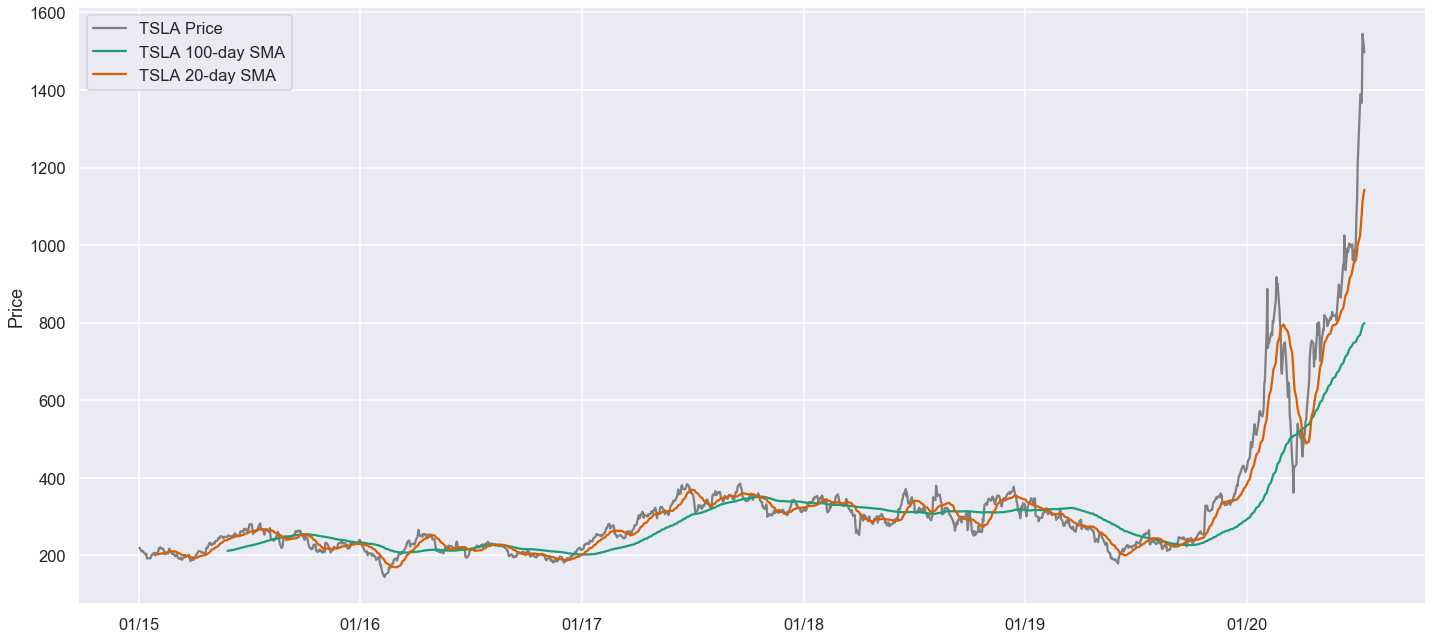

In [5]:
# Plot closing price, long rolling average, and short rolling average of individual asset using subplots
fig,ax = plt.subplots(figsize = (20,9))

ax.plot(df['TSLA'], label = 'TSLA Price', c = 'gray')
ax.plot(long_rolling['TSLA'], label = 'TSLA 100-day SMA')
ax.plot(short_rolling['TSLA'], label = 'TSLA 20-day SMA')

ax.legend(loc = 'upper left')
ax.set_ylabel('Price')
# Change x-axis to be "month/year" format using date_format variable previously established
ax.xaxis.set_major_formatter(date_format)

plt.tight_layout()

# Exponential Moving Average (No Pos. Size Provision)

In [6]:
# Account for time-lag in rolling averages by creating an exponential moving average dataframe from our original 
# Setting the argument 'adjust = False' indicates that we are using a recursive calculation
ema_short = df.ewm(span = 20, adjust = False).mean()

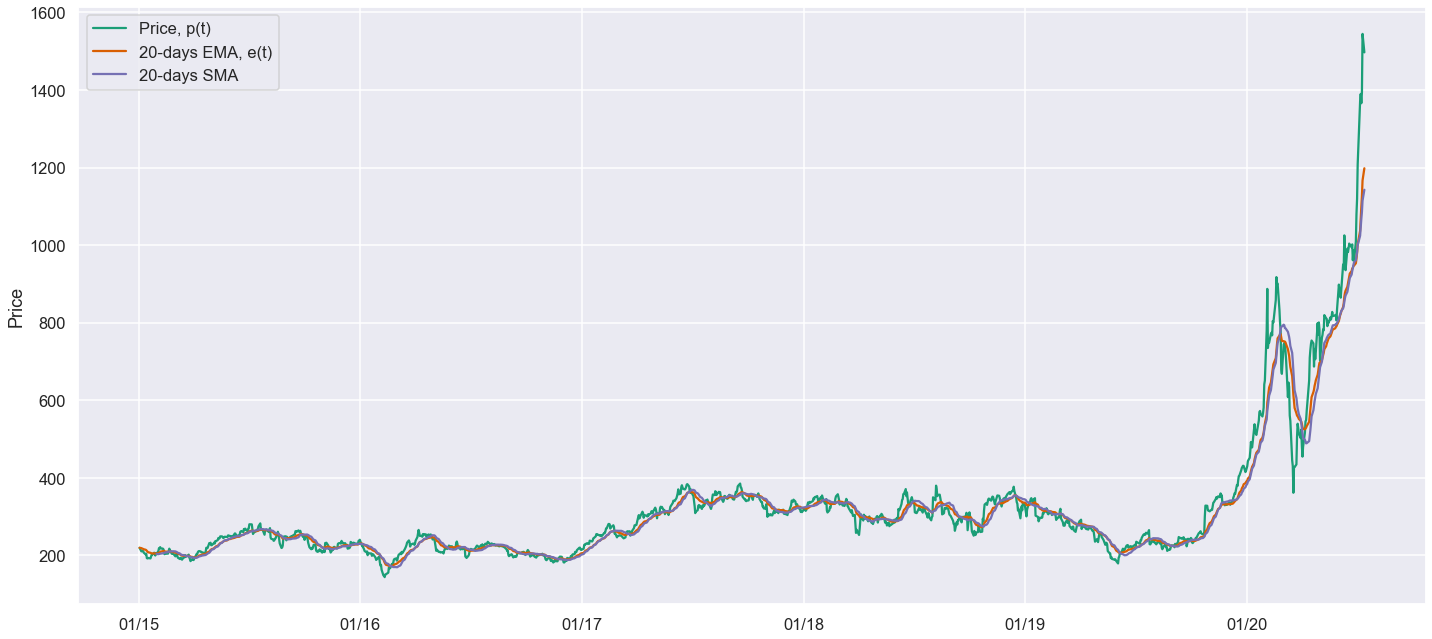

In [7]:
# Plot exponential moving average time series along with the original price time series and the short rolling average time series
fig, ax = plt.subplots(figsize = (20,9))
ax.plot(df.TSLA, label = 'Price, p(t)')
ax.plot(ema_short.TSLA, label = '20-days EMA, e(t)')
ax.plot(short_rolling.TSLA, label = '20-days SMA')

ax.legend(loc = 'upper left')
ax.set_ylabel('Price')
ax.xaxis.set_major_formatter(date_format)

plt.tight_layout()

* When the price timeseries p(t) crosses the EMA timeseries e(t) from below, we will close any existing short position and go long (buy) one unit of the asset.
     - pi(t)>ei(t) , then wi(t)= 1/3
* When the price timeseries p(t) crosses the EMA timeseries e(t) from above, we will close any existing long position and go short (sell) one unit of the asset.
     -  pi(t)<ei(t), then wi(t)= -1/3

In [8]:
# Price differences between asset closing price and exponential MA series
trade_pos_raw = df - ema_short
trade_pos_raw.tail()

,TSLA,JNJ,AAPL
Date,,,
2020-07-07,319.344658,0.477997,17.479819
2020-07-08,267.234690,0.812473,23.668408
2020-07-09,267.479006,0.029380,22.898083
2020-07-10,378.053862,-0.081989,21.323504
2020-07-13,298.991113,2.495343,17.691265


In [9]:
# Take the sign of the trade position difference (1 if x > 0; -1 if x < 0 ) and multiply by the fixed weight of assets (1/3 due to three assets)
trade_positions = trade_pos_raw.apply(np.sign) * 1/3
trade_positions.tail()

,TSLA,JNJ,AAPL
Date,,,
2020-07-07,0.333333,0.333333,0.333333
2020-07-08,0.333333,0.333333,0.333333
2020-07-09,0.333333,0.333333,0.333333
2020-07-10,0.333333,-0.333333,0.333333
2020-07-13,0.333333,0.333333,0.333333


In [10]:
# Lag trading signals by a day (we are assuming that we traded at close of day t0 so we will have a long position 
# on day t0+1)
trading_pos_final = trade_positions.shift(1)

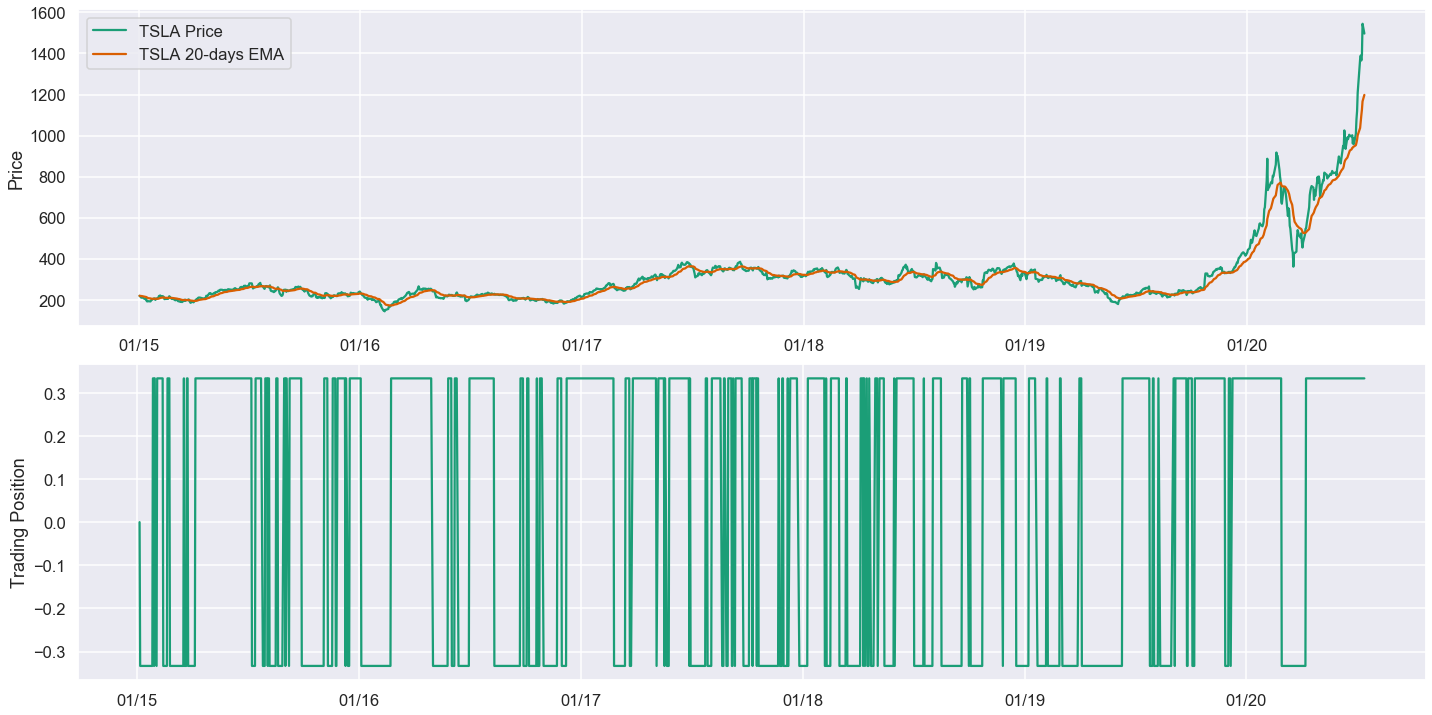

In [11]:
# Plot timeseries and respective trading position for an asset in the portfolio
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 10))

ax1.plot(df.TSLA, label = 'TSLA Price')
ax1.plot(ema_short.TSLA, label = 'TSLA 20-days EMA')
ax1.set_ylabel('Price')
ax1.legend(loc = 'upper left')
ax1.xaxis.set_major_formatter(date_format)

ax2.plot(trading_pos_final.TSLA, label = 'TSLA Trade Position')
ax2.set_ylabel('Trading Position')
ax2.xaxis.set_major_formatter(date_format)

plt.tight_layout()

# Strategy Performance

In [12]:
# Take log of prices and then the difference of consecutive log observations
asset_log_returns = np.log(df).diff()
asset_log_returns.head()

,TSLA,JNJ,AAPL
Date,,,
2015-01-02,NaN,NaN,NaN
2015-01-05,-0.042950,-0.007032,-0.028620
2015-01-06,0.005648,-0.004940,0.000103
2015-01-07,-0.001563,0.021932,0.013903
2015-01-08,-0.001566,0.007788,0.037755


In [13]:
# Multiply strategy positions with asset log returns
asset_log_returns = trading_pos_final * asset_log_returns
asset_log_returns.tail()

,TSLA,JNJ,AAPL
Date,,,
2020-07-07,0.004413,-0.000303,-0.001036
2020-07-08,-0.005801,0.000979,0.007674
2020-07-09,0.006860,-0.001820,0.001430
2020-07-10,0.034140,-0.000281,0.000583
2020-07-13,-0.010431,-0.006584,-0.001541


In [14]:
# Get cumulative log-returns per asset
cumul_asset_log_returns = asset_log_returns.cumsum()
# Transform to relative returns
cumul_asset_relative_returns = np.exp(cumul_asset_log_returns) - 1

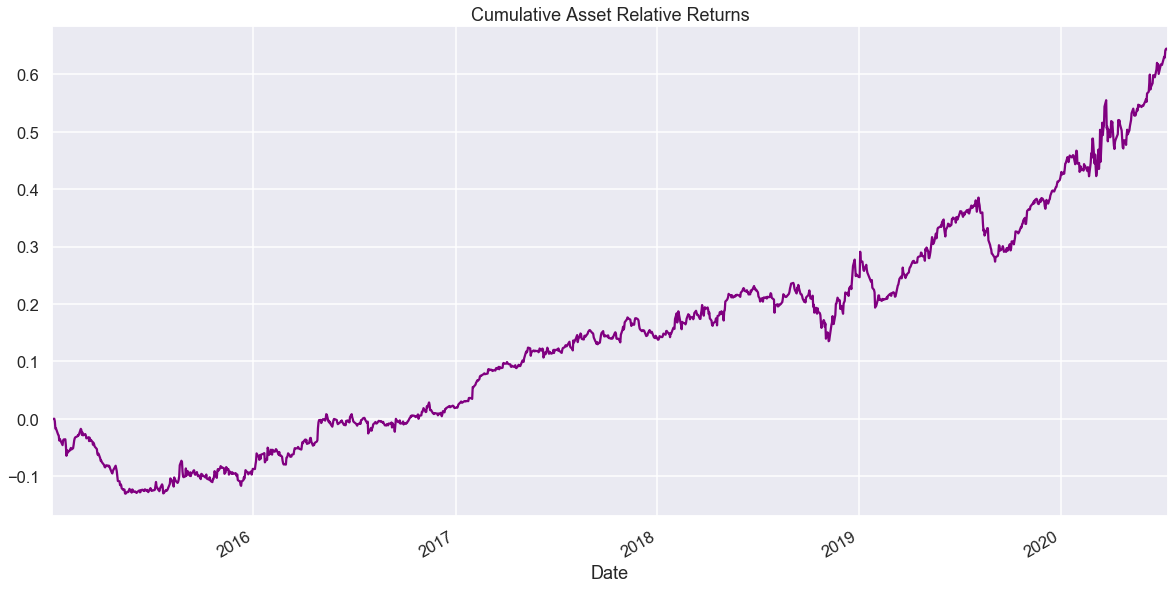

In [15]:
cumul_asset_relative_returns.AAPL.plot(kind = 'line', figsize = (20,10), color = 'purple', title = 'Cumulative Asset Relative Returns')

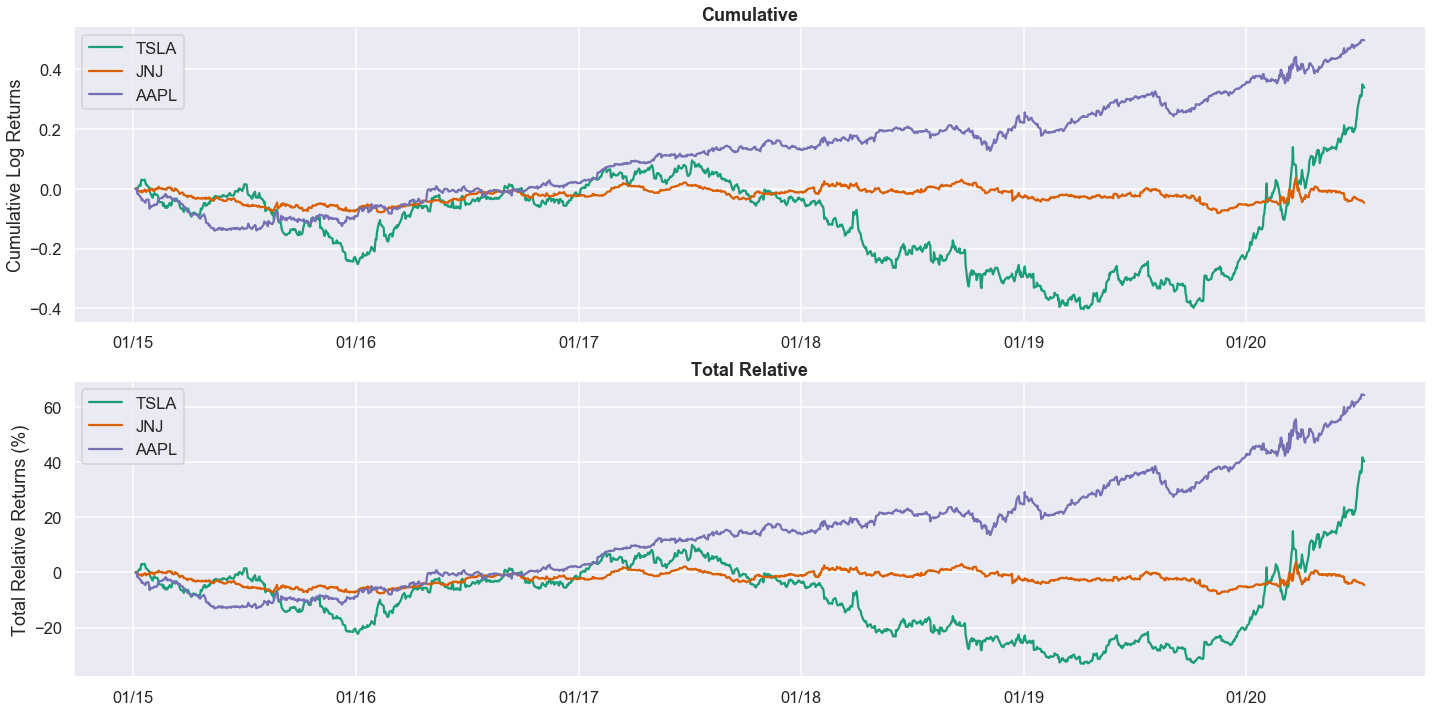

In [16]:
# Plot the cumulative log returns of asset portfolio in addition to plotting the total relative return
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 10))

for c in asset_log_returns:
    ax1.plot(cumul_asset_log_returns.index, cumul_asset_log_returns[c], label = str(c))
    
ax1.set_ylabel('Cumulative Log Returns')
ax1.legend(loc = 'best')
ax1.xaxis.set_major_formatter(date_format)
ax1.set_title('Cumulative', fontweight = 'bold')

for c in asset_log_returns:
    ax2.plot(cumul_asset_relative_returns.index, 100*cumul_asset_relative_returns[c], label = str(c))
    
ax2.set_ylabel('Total Relative Returns (%)')
ax2.legend(loc = 'best')
ax2.xaxis.set_major_formatter(date_format)
ax2.set_title('Total Relative', fontweight = 'bold')

plt.tight_layout()

# Total Strategy Return

In [17]:
# Total strategy relative returns 
cumul_relative_return_exact = cumul_asset_relative_returns.sum(axis = 1)
# Cumulative log-returns per asset
cumul_log_return = cumul_asset_log_returns.sum(axis = 1)
# Turn cumulative log returns to approximate relative returns
cumul_relative_return_appx = np.exp(cumul_log_return) - 1

In [18]:
cumul_relative_return_appx

Date
2015-01-02    0.000000
2015-01-05    0.000000
2015-01-06   -0.000270
2015-01-07   -0.011626
2015-01-08   -0.020939
                ...   
2020-07-07    1.142665
2020-07-08    1.148783
2020-07-09    1.162732
2020-07-10    1.238517
2020-07-13    1.197361
Length: 1391, dtype: float64

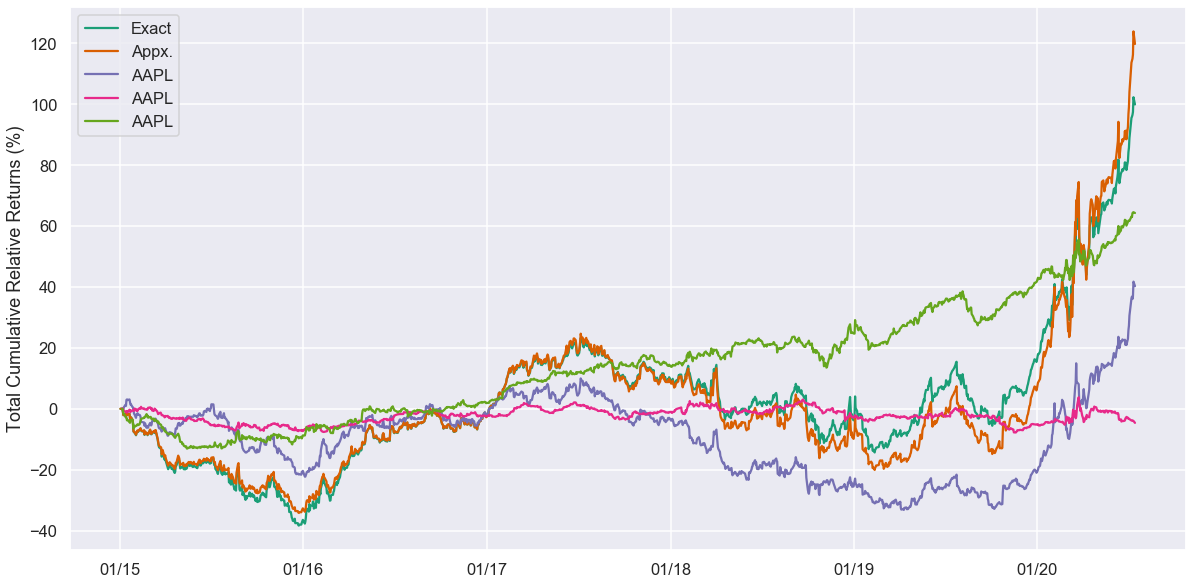

In [19]:
# Plot Exact and Approximate equity curves
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(cumul_relative_return_exact.index, 100*cumul_relative_return_exact, label = 'Exact')
ax.plot(cumul_relative_return_appx.index, 100*cumul_relative_return_appx, label = 'Appx.')
ax.plot(cumul_asset_relative_returns.AAPL.index, 100*cumul_asset_relative_returns, label = 'AAPL')

ax.set_ylabel('Total Cumulative Relative Returns (%)')
ax.legend(loc = 'upper left')
ax.xaxis.set_major_formatter(date_format)

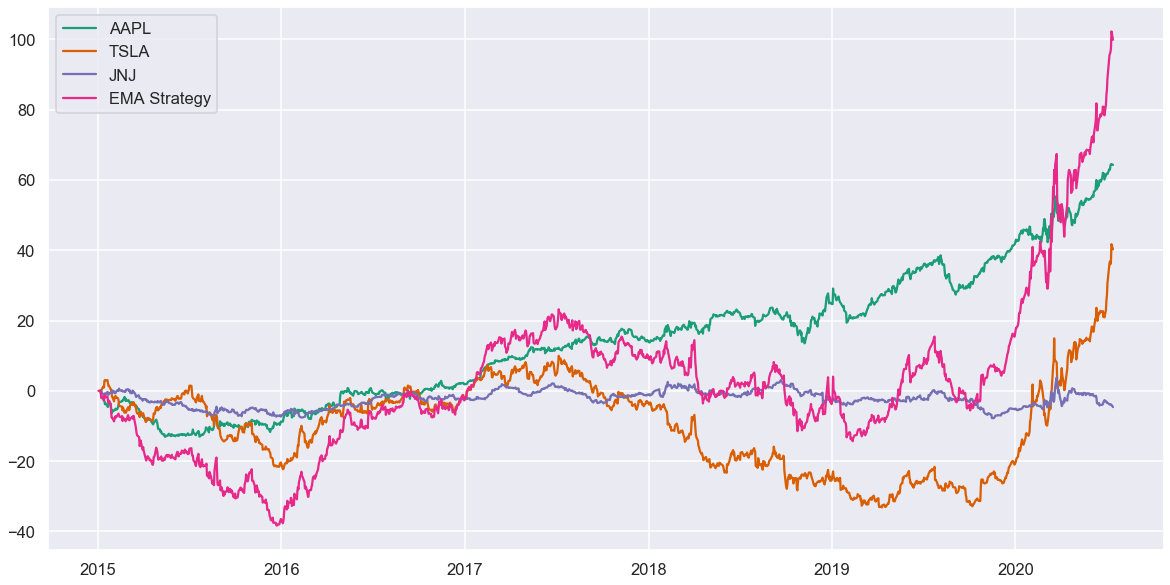

In [20]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(cumul_asset_relative_returns.AAPL.index, 100*cumul_asset_relative_returns.AAPL, label = 'AAPL')
ax.plot(cumul_asset_relative_returns.TSLA.index, 100*cumul_asset_relative_returns.TSLA, label = 'TSLA')
ax.plot(cumul_asset_relative_returns.JNJ.index, 100*cumul_asset_relative_returns.JNJ, label = 'JNJ')
ax.plot(cumul_relative_return_exact.index, 100*cumul_relative_return_exact, label = 'EMA Strategy')
plt.legend()

In [21]:
# Define a function to print lifetime total portfolio returns and average yearly returns
def print_yearly_statistics(portfolio_cumulative_relative_returns, days_per_year = 52*5):
    total_days_in_sim = portfolio_cumulative_relative_returns.shape[0]
    number_of_years = total_days_in_sim/days_per_year
    
    # Take final data point as the most recent total return to portfolio
    total_portfolio_return = portfolio_cumulative_relative_returns[-1]
    # Average portfolio return with compound return assumption
    average_yearly_return = (1 + total_portfolio_return)**(1/number_of_years) - 1
    
    print('Total portfolio return is: ' + '{:5.2f}'.format(100*total_portfolio_return)+'%')
    print('Average yearly return is: ' + '{:5.2f}'.format(100*average_yearly_return) + '%')
    

In [22]:
print_yearly_statistics(cumul_relative_return_exact)

Total portfolio return is: 99.89%
Average yearly return is: 13.82%



# Strategy Comparison with Simply Buy-and-Hold Strategy

In [23]:
# Instantaite a new DF withvaflues = 1/3 to represent tertiary weight of portfolio
simple_weights_matrix = pd.DataFrame(1/3, index = df.index, columns = df.columns)
# Simple strategy log returns 
simple_strategy_asset_log_returns = simple_weights_matrix * asset_log_returns
# Cumulative log-returns per asset
simple_cum_strategy_asset_log_returns = simple_strategy_asset_log_returns.cumsum()
# Transform cumulative log returns to relative returns
simple_cum_strategy_asset_relative_returns = np.exp(simple_cum_strategy_asset_log_returns) - 1
# Total relative returns for simple strategy
simple_cum_relative_return_exact = simple_cum_strategy_asset_relative_returns.sum(axis = 1)

Total portfolio return is: 28.36%
Average yearly return is:  4.78%


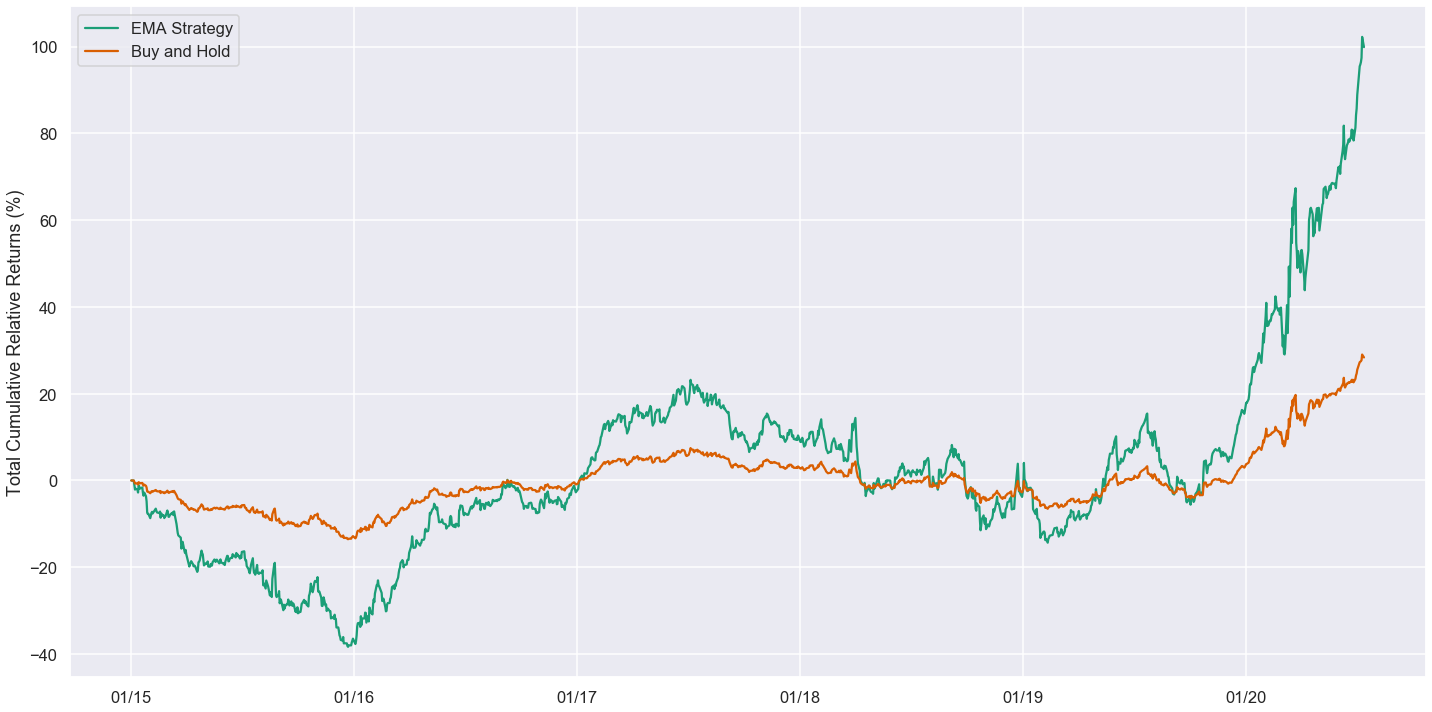

In [24]:
# Plot exponential moving average crossover strategy against simple buy and hold strategy
fig, ax = plt.subplots(figsize = (20, 10))

ax.plot(cumul_relative_return_exact.index, 100*cumul_relative_return_exact, label = 'EMA Strategy')
ax.plot(simple_cum_relative_return_exact.index, 100*simple_cum_relative_return_exact, label = 'Buy and Hold')

ax.set_ylabel('Total Cumulative Relative Returns (%)')
ax.legend(loc = 'best')
ax.xaxis.set_major_formatter(date_format)
plt.tight_layout()

print_yearly_statistics(simple_cum_relative_return_exact)